# Getting Started with RFInject

This notebook demonstrates how to use the `rfinject` toolkit to explore and analyze SAR data.

## Project Setup

This project uses `pdm` for dependency management. Before running this notebook, please ensure you have installed the dependencies by running the following command in your terminal from the project's root directory:

```bash
pdm install
```

This will set up a virtual environment with all the required packages. Make sure your Jupyter kernel is pointing to this environment.

## Autoreload

The following cell loads the `autoreload` extension. This is useful for development, as it automatically reloads modules before executing code. If you make changes to `.py` files in the `rfinject` library, they will be reflected here without needing to restart the kernel.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from typing import Dict, List, Any, Tuple, Optional
import matplotlib.pyplot as plt
from scipy.signal import welch
import zarr


from rfinject.utils import *
from rfinject.viz   import *

# print zarr version and pyhthon version
print("Python version:", sys.version)
print("Zarr version:", zarr.__version__)


path = 's1a-iw-raw-s-hh-20240116t204634-20240116t204707-052137-064d52.zarr'
data =  zarr.open(path, mode='r')

Python version: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:44:42) [Clang 18.1.8 ]
Zarr version: 3.1.3


In [3]:
# Explore the complete structure
explore_zarr_structure(data)

Zarr Structure:
📁 burst_32/
  📄 echo: (1410, 19656) complex64
  📄 rfi: (15, 1410, 19656) complex64
📁 burst_3/
  📄 rfi: (15, 1409, 23726) complex64
  📄 echo: (1409, 23726) complex64
📁 burst_2/
  📄 rfi: (15, 1410, 19656) complex64
  📄 echo: (1410, 19656) complex64
📁 burst_4/
  📄 rfi: (15, 1548, 23996) complex64
  📄 echo: (1548, 23996) complex64
📁 burst_16/
📁 burst_32/
  📄 echo: (1410, 19656) complex64
  📄 rfi: (15, 1410, 19656) complex64
📁 burst_3/
  📄 rfi: (15, 1409, 23726) complex64
  📄 echo: (1409, 23726) complex64
📁 burst_2/
  📄 rfi: (15, 1410, 19656) complex64
  📄 echo: (1410, 19656) complex64
📁 burst_4/
  📄 rfi: (15, 1548, 23996) complex64
  📄 echo: (1548, 23996) complex64
📁 burst_16/
  📄 rfi: (15, 1548, 23996) complex64
  📄 echo: (1548, 23996) complex64
📁 burst_33/
  📄 echo: (1409, 23726) complex64
  📄 rfi: (15, 1409, 23726) complex64
📁 burst_34/
  📄 rfi: (15, 1548, 23996) complex64
  📄 echo: (1548, 23996) complex64
📁 burst_29/
  📄 echo: (1410, 19656) complex64
  📄 rfi: (15, 1410,

In [4]:
# Get detailed information about all bursts
burst_info = get_burst_info(data)

print('📊 Burst Information Summary:')
print(f'Total number of bursts: {len(burst_info)}')
print(f"=" * 40)

for burst_name, info in list(burst_info.items())[:2]:
    print(f'🚀 {burst_name}:')
    print(f'  Total size: {info["total_size_mb"]:.1f} MB')
    
    for array_name, array_info in info['arrays'].items():
        print(f'  📄 {array_name}:')
        print(f'    Shape: {array_info["shape"]}')
        print(f'    Type: {array_info["dtype"]}')
        print(f'    Size: {array_info["size_mb"]:.1f} MB')
        if array_info['chunks']:
            print(f'    Chunks: {array_info["chunks"]}')
    print(f"=" * 40)
    print()

📊 Burst Information Summary:
Total number of bursts: 36
🚀 burst_35:
  Total size: 955.0 MB
  📄 rfi:
    Shape: (15, 398, 19656)
    Type: complex64
    Size: 895.3 MB
    Chunks: (2, 50, 2457)
  📄 echo:
    Shape: (398, 19656)
    Type: complex64
    Size: 59.7 MB
    Chunks: (50, 2457)

🚀 burst_29:
  Total size: 3383.2 MB
  📄 rfi:
    Shape: (15, 1410, 19656)
    Type: complex64
    Size: 3171.7 MB
    Chunks: (1, 177, 2457)
  📄 echo:
    Shape: (1410, 19656)
    Type: complex64
    Size: 211.4 MB
    Chunks: (89, 2457)



Accessing the data

In [5]:
# Example: Access echo data from burst_0
echo_array = access_array_data(data, 'burst_0', 'echo')
rfi_array = access_array_data(data, 'burst_0', 'rfi')

print(f'📡 Echo array from burst_0:')
print(f'  Shape: {echo_array.shape}')
print(f'  Type: {echo_array.dtype}')
print(f'  Chunks: {echo_array.chunks}')


# Get a small slice for inspection
echo_slice = get_array_slice(echo_array, slice_params=(slice(300, 400), slice(1000, 2000)))
print(f'\n🔍 Small slice:')
print(f'  Shape: {echo_slice.shape}')
print(f'  Data type: {echo_slice.dtype}')

📡 Echo array from burst_0:
  Shape: (1259, 23726)
  Type: complex64
  Chunks: (79, 2966)

🔍 Small slice:
  Shape: (100, 1000)
  Data type: complex64


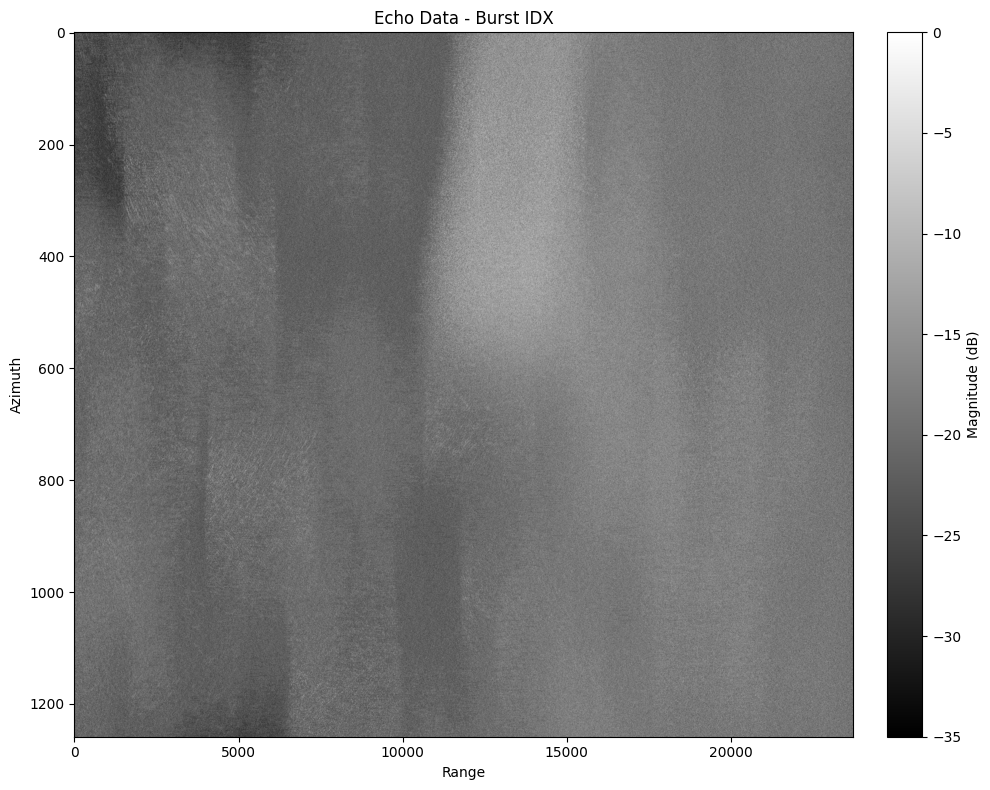

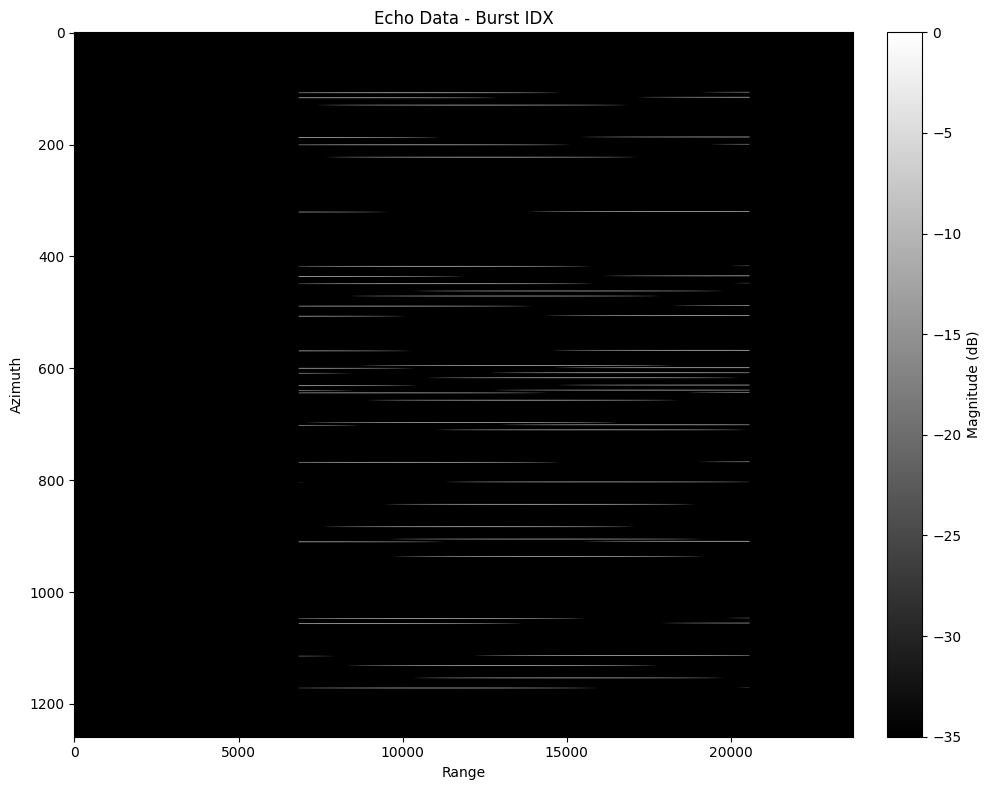

In [6]:
# Plot the echo slice
plot_magnitude(echo_array, title='Echo Data - Burst IDX', vmin=-35, vmax=0, savefig='echo_data_sample_slice.png')
plot_magnitude(rfi_array[1,:,:], title='Echo Data - Burst IDX', vmin=-35, vmax=0, savefig='echo_data_sample_slice.png') # We have 15 different RFIs encoded in channels, plot only the first one

# Ancillary Data

In [7]:
# Explore attributes
print('🏷️  Exploring Attributes:')
all_attributes = explore_all_attributes(data)

if all_attributes:
    for idx, (path, attrs) in enumerate(all_attributes.items()):
        print(f'\n📍 {path}:')
        for key, value in attrs.items():
            print(f'  {key}')
            for idy, v in enumerate(value) if isinstance(value, list) else []:
                print(f'    - {list(v.keys())}' if isinstance(v, dict) else f'    - {v}')
                if idy >=1:  # Limit output for brevity
                    print('    ...')
                    break
        if idx >=1:  # Limit output for brevity
            print('  ...')
            break
else:   
    print('No attributes found in this Zarr file.')

🏷️  Exploring Attributes:

📍 root:
  ephemeris
    - ['x', 'y', 'z', 'vx', 'vy', 'vz', 'time_stamp', 'q0', 'q1', 'q2', 'q3', 'omega_x', 'omega_y', 'omega_z', 'pointing_status', 'temperature_update_status', 'tile1_efeh_temperature', 'tile1_efev_temperature', 'tile1_ta_temperature', 'tile2_efeh_temperature', 'tile2_efev_temperature', 'tile2_ta_temperature', 'tile3_efeh_temperature', 'tile3_efev_temperature', 'tile3_ta_temperature', 'tile4_efeh_temperature', 'tile4_efev_temperature', 'tile4_ta_temperature', 'tile5_efeh_temperature', 'tile5_efev_temperature', 'tile5_ta_temperature', 'tile6_efeh_temperature', 'tile6_efev_temperature', 'tile6_ta_temperature', 'tile7_efeh_temperature', 'tile7_efev_temperature', 'tile7_ta_temperature', 'tile8_efeh_temperature', 'tile8_efev_temperature', 'tile8_ta_temperature', 'tile9_efeh_temperature', 'tile9_efev_temperature', 'tile9_ta_temperature', 'tile10_efeh_temperature', 'tile10_efev_temperature', 'tile10_ta_temperature', 'tile11_efeh_temperature', 'til

In [8]:
# Level 1: Per product attributes:
print('\n🏷️  Product-level Attributes:')
product_attributes = access_attributes(data )
ephemeris = product_attributes['ephemeris']
l0_name = product_attributes['l0_name']
ephemeris_df = pd.DataFrame(ephemeris)
ephemeris_df



🏷️  Product-level Attributes:


x             y             z           vx           vy  \
0    1.706020e+06 -2.704724e+06  6.301904e+06 -5588.694336  3993.599121   
1    1.706020e+06 -2.704724e+06  6.301904e+06 -5588.694336  3993.599121   
2    1.706020e+06 -2.704724e+06  6.301904e+06 -5588.694336  3993.599121   
3    1.706020e+06 -2.704724e+06  6.301904e+06 -5588.694336  3993.599121   
4    1.706020e+06 -2.704724e+06  6.301904e+06 -5588.694336  3993.599121   
..            ...           ...           ...          ...          ...   
789  1.526539e+06 -2.574985e+06  6.401274e+06 -5627.680664  4114.374512   
790  1.526539e+06 -2.574985e+06  6.401274e+06 -5627.680664  4114.374512   
791  1.526539e+06 -2.574985e+06  6.401274e+06 -5627.680664  4114.374512   
792  1.526539e+06 -2.574985e+06  6.401274e+06 -5627.680664  4114.374512   
793  1.526539e+06 -2.574985e+06  6.401274e+06 -5627.680664  4114.374512   

              vz         time_stamp        q0        q1        q2  ...  \
0    3219.653076  23311492201840640 -0.287888 -0.178709  0.903463  ...   
1    3219.653076  23311492201840640 -0.287888 -0.178709  0.903463  ...   
2    3219.653076  23311492201840640 -0.287888 -0.178709  0.903463  ...   
3    3219.653076  23311492201840640 -0.287888 -0.178709  0.903463  ...   
4    3219.653076  23311492201840640 -0.287888 -0.178709  0.903463  ...   
..           ...                ...       ...       ...       ...  ...   
789  2990.375977  23311492738711552 -0.271984 -0.181658  0.906542  ...   
790  2990.375977  23311492738711552 -0.271984 -0.181658  0.906542  ...   
791  2990.375977  23311492738711552 -0.271984 -0.181658  0.906542  ...   
792  2990.375977  23311492738711552 -0.271984 -0.181658  0.906542  ...   
793  2990.375977  23311492738711552 -0.271984 -0.181658  0.906542  ...   

     tile12_efeh_temperature  tile12_efev_temperature  tile12_ta_temperature  \
0                         87                       81                     85   
1                         87                       81                     85   
2                         87                       81                     85   
3                         87                       81                     85   
4                         87                       81                     85   
..                       ...                      ...                    ...   
789                       88                       82                     87   
790                       88                       82                     87   
791                       88                       82                     87   
792                       88                       82                     87   
793                       88                       82                     87   

     tile13_efeh_temperature tile13_efev_temperature  tile13_ta_temperature  \
0                         91                      83                     88   
1                         91                      83                     88   
2                         91                      83                     88   
3                         91                      83                     88   
4                         91                      83                     88   
..                       ...                     ...                    ...   
789                       92                      84                     90   
790                       92                      84                     90   
791                       92                      84                     90   
792                       92                      84                     90   
793                       92                      84                     90   

     tile14_efeh_temperature  tile14_efev_temperature  tile14_ta_temperature  \
0                         87                       78                     77   
1                         87                       78                     77   
2                         87                       78                     77

In [9]:
# Level 2: Data per burst:
print('\n📡 Data Access Examples:')
echo_array = access_array_data(data, 'burst_0', 'echo')
# Level 2: Per burst ancillary:
attributes = access_attributes(data, 'burst_0')
metadata = attributes['metadata']
metadata_df = pd.DataFrame(metadata)
rfi_parameters = attributes['rfi_params']
rfi_parameters_df = pd.DataFrame(rfi_parameters)
metadata_df


📡 Data Access Examples:


packet_version_number  packet_type  secondary_header_flag  pid  pcat  \
0                         0            0                   True   65    12   
1                         0            0                   True   65    12   
2                         0            0                   True   65    12   
3                         0            0                   True   65    12   
4                         0            0                   True   65    12   
...                     ...          ...                    ...  ...   ...   
1254                      0            0                   True   65    12   
1255                      0            0                   True   65    12   
1256                      0            0                   True   65    12   
1257                      0            0                   True   65    12   
1258                      0            0                   True   65    12   

      sequence_flags  packet_sequence_count  packet_data_length  coarse_time  \
0                  3                   3781               16997   1389473212   
1                  3                   3782               16965   1389473212   
2                  3                   3783               16941   1389473212   
3                  3                   3784               16977   1389473212   
4                  3                   3785               17005   1389473212   
...              ...                    ...                 ...          ...   
1254               3                   5035               16541   1389473213   
1255               3                   5036               16585   1389473213   
1256               3                   5037               16573   1389473213   
1257               3                   5038               16541   1389473213   
1258               3                   5039               16549   1389473213   

      fine_time  ...  swath_number  number_of_quads  signal_type_name  \
0      0.639915  ...            10            11863              echo   
1      0.640495  ...            10            11863              echo   
2      0.641075  ...            10            11863              echo   
3      0.641670  ...            10            11863              echo   
4      0.642250  ...            10            11863              echo   
...         ...  ...           ...              ...               ...   
1254   0.370201  ...            10            11863              echo   
1255   0.370796  ...            10            11863              echo   
1256   0.371376  ...            10            11863              echo   
1257   0.371956  ...            10            11863              echo   
1258   0.372536  ...            10            11863              echo   

      data_take_hex  samples_per_line  polarization_name  temp_comp_name  \
0        0x0C9AA560             23726                H-V        disabled   
1        0x0C9AA560             23726                H-V        disabled   
2        0x0C9AA560             23726                H-V        disabled   
3        0x0C9AA560             23726                H-V        disabled   
4        0x0C9AA560             23726                H-V        disabled   
...             ...               ...                ...             ...   
1254     0x0C9AA560             23726                H-V        disabled   
1255     0x0C9AA560             23726                H-V        disabled   
1256     0x0C9AA560             23726                H-V        disabled   
1257     0x0C9AA560             23726                H-V        disabled   
1258     0x0C9AA560             23726                H-V        disabled   

      sync_marker_valid  baq_mode_valid  packet_version_valid  
0                  True            True                  True  
1                  True            True                  True  
2                  True            True                  True  
3                  True            True                  True 

# RFI

In [ ]:
# Assuming sqdT is equivalent to filtered_data and RadPar.fs is the sampling frequency
sampling_frequency = 300e6  # 300 MHz

filtered_data = access_array_data(data, 'burst_0', 'echo')

# Compute the power spectral density
# Convert zarr array to numpy array and flatten it
data_array = np.array(filtered_data)
frequencies, psd = welch(data_array.flatten(), nperseg=data_array.shape[0], noverlap=None, nfft=data_array.shape[1], fs=sampling_frequency, return_onesided=False)

# Shift the zero frequency component to the center
frequencies = np.fft.fftshift(frequencies)
psd = np.fft.fftshift(psd)

# Plot the power spectral density
plt.figure(figsize=(6, 6), dpi=120)
plt.plot(frequencies, 10 * np.log10(psd))
plt.title('Power Spectral Density of Filtered Data (dB)')
plt.xlabel('Frequency')
plt.ylabel('dB')
plt.gca()
plt.grid(True)
plt.show()

In [11]:
rfi_parameters_df

freqShift            fc     SIR_dB            bw   PRF      duty  Gain  \
0   2.549169e+07  5.430492e+09  -6.470562  1.799656e+06  1192  0.189092   1.0   
1  -3.253719e+06  5.401747e+09  -8.964715  1.814020e+06  1058  0.171039   1.0   
2  -1.897160e+07  5.386029e+09 -19.091863  2.389713e+06  1488  0.333521   1.0   
3   1.709304e+07  5.422093e+09 -12.539714  1.233095e+06  1142  0.415674   1.0   
4  -7.540922e+06  5.397460e+09 -12.677303  2.035693e+06  1820  0.248688   1.0   
5  -7.922024e+06  5.397078e+09 -15.307912  1.891831e+06  1677  0.138811   1.0   
6   2.572028e+06  5.407572e+09 -16.948202  2.153497e+06  1659  0.467965   1.0   
7   1.020084e+07  5.415201e+09 -18.368402  7.990228e+05  1536  0.424700   1.0   
8   1.230061e+06  5.406231e+09 -24.090075  9.069183e+05  1704  0.104601   1.0   
9  -2.645318e+07  5.378547e+09 -10.637534  1.104444e+06  1638  0.496489   1.0   
10  2.971929e+06  5.407972e+09 -12.840784  2.100324e+06  1785  0.269789   1.0   
11 -6.093253e+06  5.398907e+09 -10.529609  3.610930e+05  1855  0.246328   1.0   
12 -1.069736e+07  5.394303e+09 -23.717712  2.024160e+06  1676  0.389711   1.0   
13 -1.448571e+07  5.390515e+09  -9.805594  2.472827e+06  1551  0.289198   1.0   
14 -2.693158e+07  5.378069e+09 -14.927559  2.479527e+06  1489  0.238951   1.0   

      Lambda         T             K  \
0   0.055205  0.000159  1.134470e+10   
1   0.055499  0.000162  1.122104e+10   
2   0.055661  0.000224  1.066166e+10   
3   0.055291  0.000364  3.387740e+09   
4   0.055543  0.000137  1.489801e+10   
5   0.055547  0.000083  2.285556e+10   
6   0.055439  0.000282  7.634440e+09   
7   0.055361  0.000276  2.889801e+09   
8   0.055453  0.000061  1.477414e+10   
9   0.055739  0.000303  3.643749e+09   
10  0.055435  0.000151  1.389636e+10   
11  0.055528  0.000133  2.719247e+09   
12  0.055576  0.000233  8.705151e+09   
13  0.055615  0.000186  1.326205e+10   
14  0.055744  0.000160  1.545091e+10   

                                                    t    AffectedAz  \
0   [-7.931701019947535e-05, -7.930146903389529e-0...   [345, 1104]   
1   [-8.08312013447603e-05, -8.081566017918023e-05...    [99, 1208]   
2   [-0.000112070385570593, -0.0001120548444050129...    [84, 1184]   
3   [-0.000181993667821788, -0.0001819781266562079...    [250, 698]   
4   [-6.832098296493427e-05, -6.830544179935421e-0...    [145, 309]   
5   [-4.138666097482064e-05, -4.137111980924058e-0...   [291, 1037]   
6   [-0.00014103830775932634, -0.00014102276659374...   [849, 1162]   
7   [-0.00013824876744915156, -0.00013823322628357...    [437, 975]   
8   [-3.0692750388453364e-05, -3.0677209222873304e...   [488, 1001]   
9   [-0.00015155328114662526, -0.00015153773998104...   [470, 1248]   
10  [-7.557102043926493e-05, -7.555547927368487e-0...   [771, 1160]   
11  [-6.639578481238514e-05, -6.638024364680508e-0...    [19, 1163]   
12  [-0.00011626221116024435, -0.00011624666999466...   [650, 1216]   
13  [-9.322939983103002e-05, -9.321385866544996e-0...    [366, 895]   
14  [-8.023889441558905e-05, -8.022335325000899e-0...  [1031, 1112]   

        AffectedRg  
0    [7967, 11618]  
1    [6846, 20576]  
2     [957, 22677]  
3    [3725, 17296]  
4      [111, 7073]  
5    [2298, 21498]  
6    [9284, 17977]  
7     [268, 20500]  
8   [17955, 23672]  
9    [8356, 14379]  
10     [17, 12424]  
11   [4556, 18540]  
12    [320, 12967]  
13   [3407, 19711]  
14  [10311, 21127]

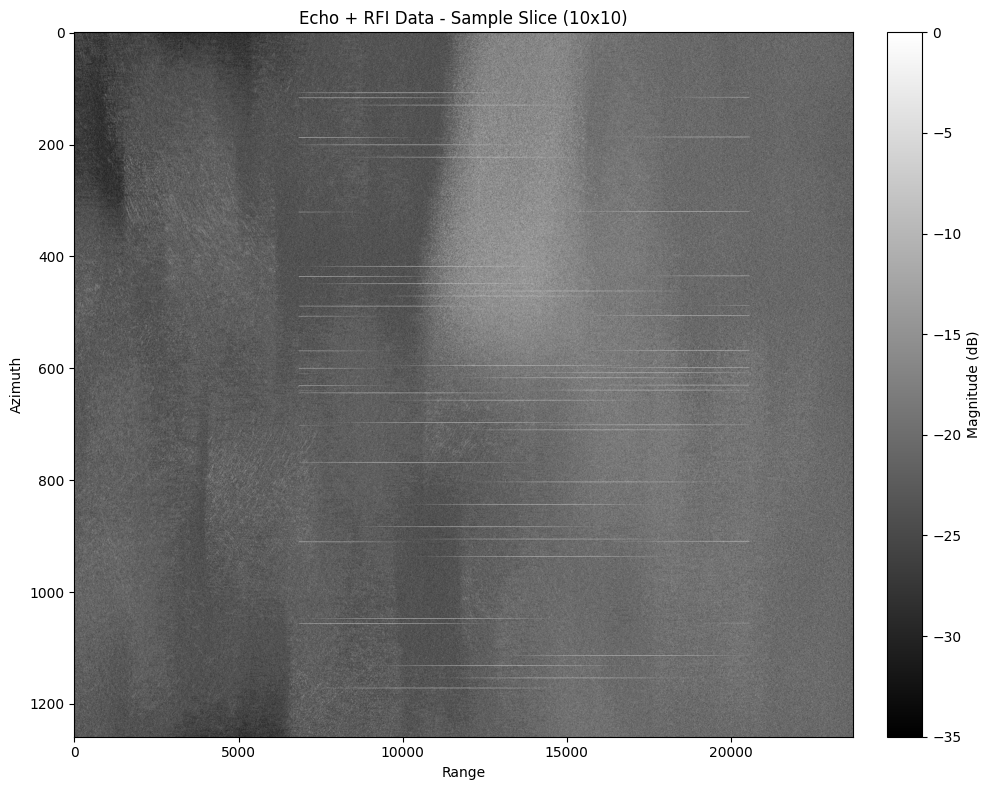

In [10]:
rfi_idx = 1
# Plotter for Echo + RFI
plot_magnitude(access_array_data(data, 'burst_0', 'rfi')[rfi_idx,:,:] + access_array_data(data, 'burst_0', 'echo'), title='Echo + RFI Data - Sample Slice (10x10)', vmin=-35, vmax=0, savefig='echo_rfi_data_sample_slice.png')